# Подготовка данных

In [4]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import os
import random
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD


# Задание seed для воспроизводимости
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_seed(52) # 52 bratuha


# Подготовка данных
train_df = pd.read_csv("loan_train.csv")
test_df = pd.read_csv("loan_test.csv")

train_df.drop(columns=["id"], inplace=True)
test_df.drop(columns=["id"], inplace=True)

target_col = "loan_status"

X_train = train_df.drop(columns=[target_col])
y_train = train_df[target_col]

X_test = test_df.drop(columns=[target_col])
y_test = test_df[target_col]


cat_features = X_train.select_dtypes(include=["object"]).columns.tolist()
num_features = X_train.select_dtypes(exclude=["object"]).columns.tolist()


encoders = {}
embedding_sizes = {}

for col in cat_features:
    print(col, X_train[col].unique())
    le = LabelEncoder()
    full_col = pd.concat([X_train[col], X_test[col]], axis=0)
    le.fit(full_col)

    encoders[col] = le
    embedding_sizes[col] = len(le.classes_)

    X_train[col] = le.transform(X_train[col])
    X_test[col] = le.transform(X_test[col])

person_home_ownership ['MORTGAGE' 'RENT' 'OWN' 'OTHER']
loan_intent ['EDUCATION' 'HOMEIMPROVEMENT' 'MEDICAL' 'DEBTCONSOLIDATION' 'VENTURE'
 'PERSONAL']
loan_grade ['A' 'D' 'B' 'C' 'F' 'E' 'G']
cb_person_default_on_file ['N' 'Y']


In [5]:
scaler = StandardScaler()
X_train[num_features] = scaler.fit_transform(X_train[num_features])
X_test[num_features] = scaler.transform(X_test[num_features])

X_train_cat = torch.tensor(X_train[cat_features].values, dtype=torch.long)     # int64 для Embedding
X_test_cat = torch.tensor(X_test[cat_features].values, dtype=torch.long)

X_train_num = torch.tensor(X_train[num_features].values, dtype=torch.float32)
X_test_num = torch.tensor(X_test[num_features].values, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

train_dataset = TensorDataset(X_train_cat, X_train_num, y_train_tensor)
test_dataset = TensorDataset(X_test_cat, X_test_num, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# Trainer

In [6]:
'cuda' if torch.cuda.is_available() else 'cpu'

'cpu'

In [7]:
class Trainer:
    def __init__(self, model, train_loader, test_loader,
                 learning_rate=0.01, weight_decay=0.0,
                 epochs=10, device='cuda' if torch.cuda.is_available() else 'cpu'):

        self.device = device
        self.model = model.to(self.device)
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.epochs = epochs

        self.criterion = nn.BCEWithLogitsLoss()
        self.optimizer = SGD(self.model.parameters(), lr=learning_rate, weight_decay=weight_decay)

        self.train_losses = []
        self.test_losses = []
        self.train_aucs = []
        self.test_aucs = []

    def train(self):
        for epoch in range(1, self.epochs + 1):
            train_loss, train_auc = self._train_one_epoch()
            test_loss, test_auc = self._evaluate()

            self.train_losses.append(train_loss)
            self.test_losses.append(test_loss)
            self.train_aucs.append(train_auc)
            self.test_aucs.append(test_auc)

            print(f"Epoch {epoch}/{self.epochs} | "
                  f"Train Loss: {train_loss:.4f}, AUC: {train_auc:.4f} | "
                  f"Test Loss: {test_loss:.4f}, AUC: {test_auc:.4f}")

    def _train_one_epoch(self):
        self.model.train()
        epoch_loss = 0
        preds, targets = [], []

        for x_cat, x_num, yb in self.train_loader:
            x_cat = x_cat.to(self.device)
            x_num = x_num.to(self.device)
            yb = yb.to(self.device)

            self.optimizer.zero_grad()
            logits = self.model(x_cat, x_num).squeeze(1)
            loss = self.criterion(logits, yb)
            loss.backward()
            self.optimizer.step()

            epoch_loss += loss.item() * x_cat.size(0)
            preds.extend(torch.sigmoid(logits).detach().cpu().numpy())
            targets.extend(yb.detach().cpu().numpy())

        epoch_loss /= len(self.train_loader.dataset)
        auc = roc_auc_score(targets, preds)
        return epoch_loss, auc

    def _evaluate(self):
        self.model.eval()
        epoch_loss = 0
        preds, targets = [], []

        with torch.no_grad():
            for x_cat, x_num, yb in self.test_loader:
                x_cat = x_cat.to(self.device)
                x_num = x_num.to(self.device)
                yb = yb.to(self.device)

                logits = self.model(x_cat, x_num).squeeze(1)
                loss = self.criterion(logits, yb)

                epoch_loss += loss.item() * x_cat.size(0)
                preds.extend(torch.sigmoid(logits).cpu().numpy())
                targets.extend(yb.cpu().numpy())

        epoch_loss /= len(self.test_loader.dataset)
        auc = roc_auc_score(targets, preds)
        return epoch_loss, auc

    def plot_metrics(self, filename_prefix=None):
        epochs_range = range(1, self.epochs + 1)

        plt.figure(figsize=(14, 5))

        # Loss plot
        plt.subplot(1, 2, 1)
        plt.plot(epochs_range, self.train_losses, label="Train Loss")
        plt.plot(epochs_range, self.test_losses, label="Test Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Loss over Epochs")
        plt.legend()

        # AUC plot
        plt.subplot(1, 2, 2)
        plt.plot(epochs_range, self.train_aucs, label="Train AUC")
        plt.plot(epochs_range, self.test_aucs, label="Test AUC")
        plt.xlabel("Epoch")
        plt.ylabel("AUC")
        plt.title("ROC-AUC over Epochs")
        plt.legend()

        plt.tight_layout()

        if filename_prefix:
            plt.savefig(f"{filename_prefix}_combined.png")
            print(f"Графики сохранены как '{filename_prefix}_combined.png'")

        plt.show()

# Эксперименты

In [8]:
def plot_all_experiments(experiments, mode='both', filename=None):
    plt.figure(figsize=(14, 5))

    # --- AUC ---
    plt.subplot(1, 2, 1)
    for exp in experiments:
        label = exp.get('label', 'unnamed')
        if mode in ['train', 'both']:
            plt.plot(exp['train_aucs'], label=f"{label} - Train AUC")
        if mode in ['test', 'both']:
            plt.plot(exp['test_aucs'], label=f"{label} - Test AUC")
    plt.title("AUC over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("ROC-AUC")
    plt.legend()

    # --- Loss ---
    plt.subplot(1, 2, 2)
    for exp in experiments:
        label = exp.get('label', 'unnamed')
        if mode in ['train', 'both']:
            plt.plot(exp['train_losses'], label=f"{label} - Train Loss")
        if mode in ['test', 'both']:
            plt.plot(exp['test_losses'], label=f"{label} - Test Loss")
    plt.title("Loss over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()

    if filename:
        plt.savefig(f"{filename}.png")
        print(f"✅ График сохранён как {filename}.png")

    plt.show()


In [9]:
def save_experiment_to_csv(experiment_dict, filename='experiment.csv'):
    df = pd.DataFrame({
        'epoch': list(range(1, len(experiment_dict['train_losses']) + 1)),
        'train_loss': experiment_dict['train_losses'],
        'test_loss': experiment_dict['test_losses'],
        'train_auc': experiment_dict['train_aucs'],
        'test_auc': experiment_dict['test_aucs']
    })

    df.to_csv(filename, index=False)
    print(f"Эксперимент сохранён в {filename}")

## Эксперимент 1

In [22]:
class SimpleMLP(nn.Module):
    def __init__(self, embedding_sizes, num_input_dim, hidden_size=32, emb_dim=4):
        super(SimpleMLP, self).__init__()

        self.embeddings = nn.ModuleList([
            nn.Embedding(num_categories, emb_dim)
            for num_categories in embedding_sizes.values()
        ])

        total_emb_dim = emb_dim * len(embedding_sizes)

        self.input_layer = nn.Linear(total_emb_dim + num_input_dim, hidden_size)

        self.block = nn.Sequential(
            nn.Linear(hidden_size, hidden_size * 4),
            nn.ReLU(),
            nn.Linear(hidden_size * 4, hidden_size)
        )

        self.output_layer = nn.Linear(hidden_size, 1)

    def forward(self, x_cat, x_num):
        x_emb = [emb_layer(x_cat[:, i]) for i, emb_layer in enumerate(self.embeddings)]
        x_emb = torch.cat(x_emb, dim=1)

        x = torch.cat([x_emb, x_num], dim=1)

        x = self.input_layer(x)
        x = self.block(x)
        x = self.output_layer(x)
        return x


Epoch 1/45 | Train Loss: 0.2920, AUC: 0.8552 | Test Loss: 0.2387, AUC: 0.9038
Epoch 2/45 | Train Loss: 0.2413, AUC: 0.8986 | Test Loss: 0.2257, AUC: 0.9115
Epoch 3/45 | Train Loss: 0.2321, AUC: 0.9045 | Test Loss: 0.2183, AUC: 0.9160
Epoch 4/45 | Train Loss: 0.2235, AUC: 0.9098 | Test Loss: 0.2107, AUC: 0.9203
Epoch 5/45 | Train Loss: 0.2156, AUC: 0.9138 | Test Loss: 0.2045, AUC: 0.9231
Epoch 6/45 | Train Loss: 0.2097, AUC: 0.9168 | Test Loss: 0.1998, AUC: 0.9244
Epoch 7/45 | Train Loss: 0.2053, AUC: 0.9190 | Test Loss: 0.1962, AUC: 0.9259
Epoch 8/45 | Train Loss: 0.2013, AUC: 0.9212 | Test Loss: 0.1936, AUC: 0.9276
Epoch 9/45 | Train Loss: 0.1982, AUC: 0.9228 | Test Loss: 0.1903, AUC: 0.9290
Epoch 10/45 | Train Loss: 0.1955, AUC: 0.9243 | Test Loss: 0.1928, AUC: 0.9294
Epoch 11/45 | Train Loss: 0.1938, AUC: 0.9248 | Test Loss: 0.1882, AUC: 0.9297
Epoch 12/45 | Train Loss: 0.1923, AUC: 0.9254 | Test Loss: 0.1865, AUC: 0.9302
Epoch 13/45 | Train Loss: 0.1909, AUC: 0.9266 | Test Loss: 0.

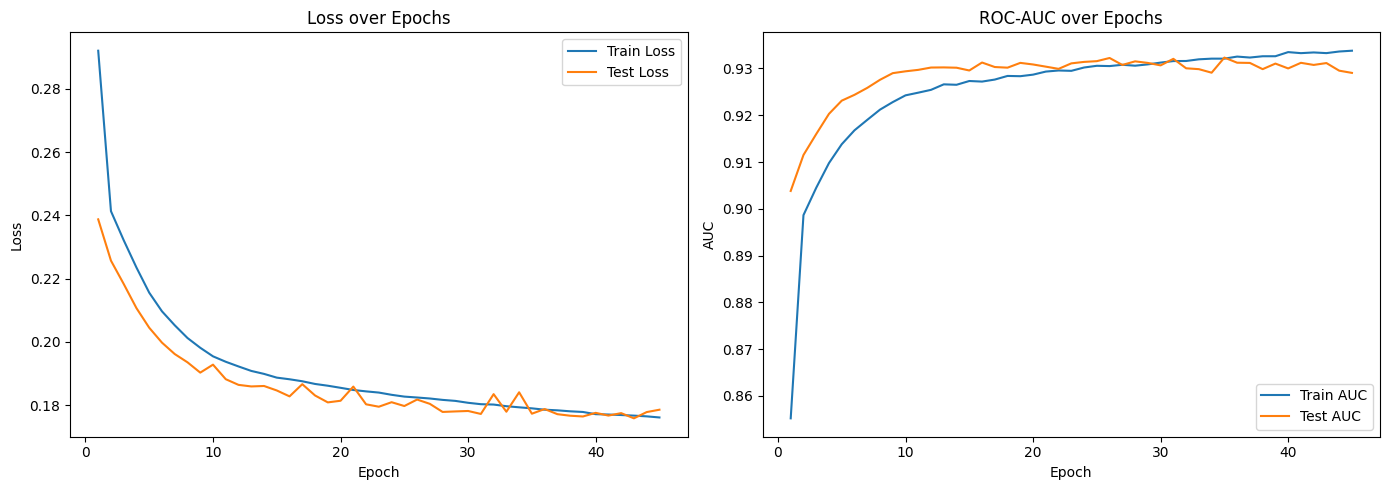

In [24]:
model = SimpleMLP(
    embedding_sizes=embedding_sizes,
    num_input_dim=X_train_num.shape[1],
    hidden_size=32,
    )

trainer = Trainer(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    learning_rate=0.01,
    epochs=45
)

trainer.train()
trainer.plot_metrics('experiment_1')

In [25]:
experiment_1 = {
    'test_aucs': trainer.test_aucs,
    'train_aucs': trainer.train_aucs,
    'test_losses': trainer.test_losses,
    'train_losses': trainer.train_losses,
    'label': "exp1"
    }
save_experiment_to_csv(experiment_1, 'experiment_1.csv')
experiment_1

Эксперимент сохранён в experiment_1.csv


{'test_aucs': [np.float64(0.9038063832573421),
  np.float64(0.9114958155260056),
  np.float64(0.915976714562922),
  np.float64(0.9202988059665956),
  np.float64(0.923119962857585),
  np.float64(0.9243675670527733),
  np.float64(0.9258511208199903),
  np.float64(0.9275801478553826),
  np.float64(0.9290027499672623),
  np.float64(0.9293956024333042),
  np.float64(0.9297067892048905),
  np.float64(0.9302017833121035),
  np.float64(0.9302303544005428),
  np.float64(0.9301658313591505),
  np.float64(0.929573219366436),
  np.float64(0.9312751038678111),
  np.float64(0.930311305817788),
  np.float64(0.9301763074249116),
  np.float64(0.9311989142986393),
  np.float64(0.9308586802538064),
  np.float64(0.930392971512244),
  np.float64(0.9299201199985715),
  np.float64(0.9310953441030464),
  np.float64(0.9314086737062653),
  np.float64(0.9315681956167189),
  np.float64(0.9322462827823478),
  np.float64(0.9307572528898466),
  np.float64(0.9315276008618945),
  np.float64(0.9311911762955203),
  np.f

In [26]:
print(max( enumerate(experiment_1["test_aucs"]), key = lambda x: x[1] ))
print(min( enumerate(experiment_1["test_losses"]), key = lambda x: x[1] ))

(34, np.float64(0.9323327103248771))
(42, 0.17588372512546646)


Выводы:
По тестовым данным
* Минимальный loss: 0.1759
* Максимальный AUC: 0.9323

Embedding-и сильно улучшили ситуацию. Но всё ещё заметно, что где-то начиная с 30-й эпохи модель особо уже не обучается.
Я бы сказал, что оптимально взять 30-40 эпох.

## Эксперимент 2

In [16]:
class MLPBlock(nn.Module):
    def __init__(self, hidden_size):
        super(MLPBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Linear(hidden_size, hidden_size * 4),
            nn.ReLU(),
            nn.Linear(hidden_size * 4, hidden_size)
        )

    def forward(self, x):
        return self.block(x)

class DeepMLP(nn.Module):
    def __init__(self, embedding_sizes, num_input_dim, hidden_size=128, num_blocks=3, emb_dim=4):
        super(DeepMLP, self).__init__()

        self.embeddings = nn.ModuleList([
            nn.Embedding(num_categories, emb_dim)
            for num_categories in embedding_sizes.values()
        ])

        total_emb_dim = emb_dim * len(embedding_sizes)
        input_dim = total_emb_dim + num_input_dim

        self.input_layer = nn.Linear(input_dim, hidden_size)

        self.blocks = nn.Sequential(
            *[MLPBlock(hidden_size) for _ in range(num_blocks)]
        )

        self.output_layer = nn.Linear(hidden_size, 1)

    def forward(self, x_cat, x_num):
        x_emb = [emb_layer(x_cat[:, i]) for i, emb_layer in enumerate(self.embeddings)]
        x_emb = torch.cat(x_emb, dim=1)
        x = torch.cat([x_emb, x_num], dim=1)

        x = self.input_layer(x)
        x = self.blocks(x)
        x = self.output_layer(x)
        return x

Epoch 1/45 | Train Loss: 0.3701, AUC: 0.7384 | Test Loss: 0.2635, AUC: 0.8988
Epoch 2/45 | Train Loss: 0.2335, AUC: 0.9060 | Test Loss: 0.2070, AUC: 0.9245
Epoch 3/45 | Train Loss: 0.2082, AUC: 0.9189 | Test Loss: 0.1964, AUC: 0.9278
Epoch 4/45 | Train Loss: 0.1968, AUC: 0.9239 | Test Loss: 0.1872, AUC: 0.9295
Epoch 5/45 | Train Loss: 0.1906, AUC: 0.9259 | Test Loss: 0.1929, AUC: 0.9290
Epoch 6/45 | Train Loss: 0.1877, AUC: 0.9273 | Test Loss: 0.1828, AUC: 0.9309
Epoch 7/45 | Train Loss: 0.1851, AUC: 0.9283 | Test Loss: 0.1825, AUC: 0.9322
Epoch 8/45 | Train Loss: 0.1835, AUC: 0.9297 | Test Loss: 0.1782, AUC: 0.9324
Epoch 9/45 | Train Loss: 0.1826, AUC: 0.9300 | Test Loss: 0.1786, AUC: 0.9318
Epoch 10/45 | Train Loss: 0.1810, AUC: 0.9310 | Test Loss: 0.1786, AUC: 0.9326
Epoch 11/45 | Train Loss: 0.1800, AUC: 0.9314 | Test Loss: 0.1877, AUC: 0.9301
Epoch 12/45 | Train Loss: 0.1793, AUC: 0.9317 | Test Loss: 0.1816, AUC: 0.9321
Epoch 13/45 | Train Loss: 0.1787, AUC: 0.9319 | Test Loss: 0.

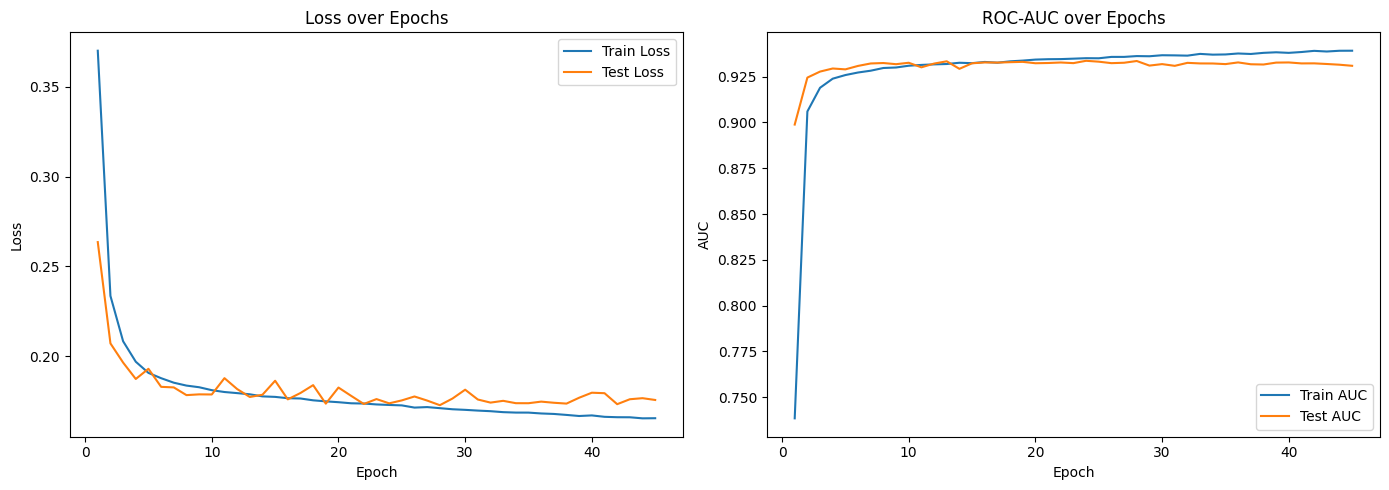

In [17]:
model = DeepMLP(
    embedding_sizes=embedding_sizes,
    num_input_dim=X_train_num.shape[1],
    hidden_size=128,
    num_blocks=3,
    emb_dim=4
)

trainer = Trainer(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    learning_rate=0.01,
    weight_decay=0.0,
    epochs=45,
)

trainer.train()
trainer.plot_metrics('experiment_2')

In [19]:
experiment_2 = {
    'test_aucs': trainer.test_aucs,
    'train_aucs': trainer.train_aucs,
    'test_losses': trainer.test_losses,
    'train_losses': trainer.train_losses,
    'label': "exp2"
    }
save_experiment_to_csv(experiment_2, 'experiment_2.csv')
experiment_2

Эксперимент сохранён в experiment_2.csv


{'test_aucs': [np.float64(0.8988383471625339),
  np.float64(0.9244935179343103),
  np.float64(0.9277753836263853),
  np.float64(0.9294603635671004),
  np.float64(0.9289884644230425),
  np.float64(0.9308751086296592),
  np.float64(0.9322098546445876),
  np.float64(0.9324486613254603),
  np.float64(0.9318149783931143),
  np.float64(0.9325915167676576),
  np.float64(0.9301010702253544),
  np.float64(0.9321441411411769),
  np.float64(0.9333957929072273),
  np.float64(0.9292798895251247),
  np.float64(0.9323029487744194),
  np.float64(0.9327650861299271),
  np.float64(0.9326824680658563),
  np.float64(0.9329093701265461),
  np.float64(0.9330869870596777),
  np.float64(0.932336281710932),
  np.float64(0.9324619945000655),
  np.float64(0.9327415149819644),
  np.float64(0.9323924715181962),
  np.float64(0.9336691229866313),
  np.float64(0.933184723991381),
  np.float64(0.932378662158784),
  np.float64(0.9325991357245748),
  np.float64(0.9335548386328735),
  np.float64(0.9310489160843324),
  np

In [20]:
print(max( enumerate(experiment_2["test_aucs"]), key = lambda x: x[1] ))
print(min( enumerate(experiment_2["test_losses"]), key = lambda x: x[1] ))

(23, np.float64(0.9336691229866313))
(27, 0.17261241352263415)


✅ График сохранён как compare_1_to_2.png


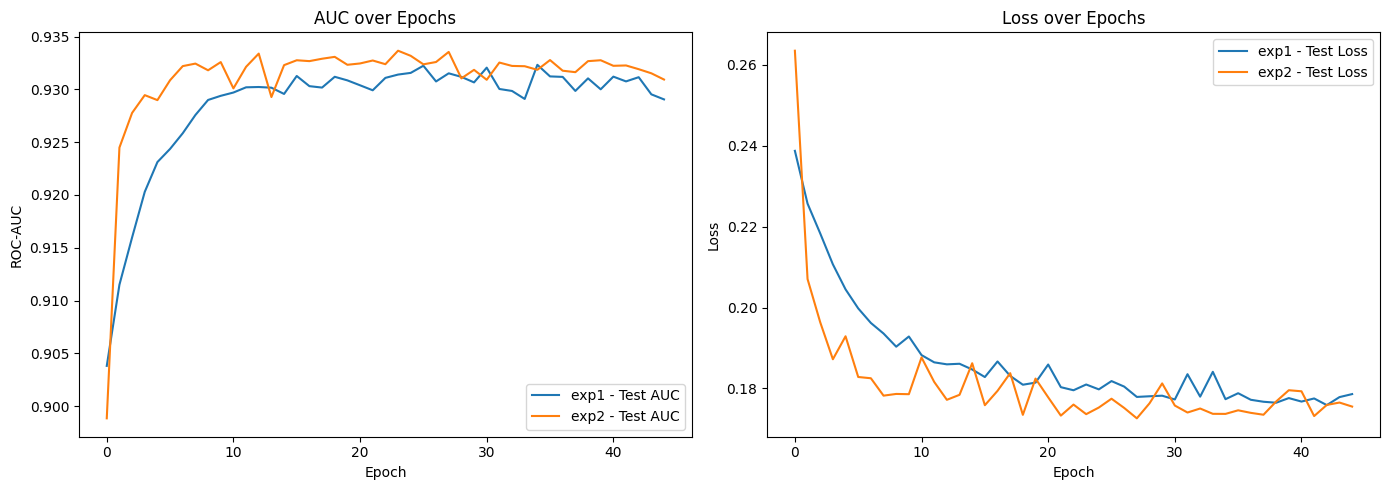

In [27]:
plot_all_experiments([experiment_1, experiment_2], 'test', 'compare_1_to_2')

Выводы:
По тестовым данным
* Минимальный loss: 0.1726
* Максимальный AUC: 0.9337

Здесь заметно, что переобучение происходит примерно на 27-й эпохе. График test_loss и test_auc стал чуть более резким и угловатым, однако в любом случае есть значительное улучшение относительно прошлой модели.

## Эксперимент 3

In [28]:
# BatchNorm + SkipConnections
class SkipBlock(nn.Module):
    def __init__(self, hidden_size):
        super(SkipBlock, self).__init__()
        self.norm = nn.BatchNorm1d(hidden_size)
        self.linear1 = nn.Linear(hidden_size, hidden_size * 4)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(hidden_size * 4, hidden_size)

    def forward(self, x):
        residual = x # skip
        out = self.norm(x)
        out = self.linear1(out)
        out = self.relu(out)
        out = self.linear2(out)
        return out + residual # добавляем skip

class SkipMLP(nn.Module):
    def __init__(self, embedding_sizes, num_input_dim, hidden_size=128, num_blocks=3, emb_dim=4):
        super(SkipMLP, self).__init__()
        self.embeddings = nn.ModuleList([
            nn.Embedding(num_categories, emb_dim)
            for num_categories in embedding_sizes.values()
        ])

        total_emb_dim = emb_dim * len(embedding_sizes)
        input_dim = total_emb_dim + num_input_dim

        self.input_layer = nn.Linear(input_dim, hidden_size)

        self.blocks = nn.Sequential(
            *[SkipBlock(hidden_size) for _ in range(num_blocks)]
        )

        self.output_layer = nn.Linear(hidden_size, 1)

    def forward(self, x_cat, x_num):
        x_emb = [emb_layer(x_cat[:, i]) for i, emb_layer in enumerate(self.embeddings)]
        x_emb = torch.cat(x_emb, dim=1)
        x = torch.cat([x_emb, x_num], dim=1)
        x = self.input_layer(x)
        x = self.blocks(x)
        x = self.output_layer(x)
        return x


Epoch 1/45 | Train Loss: 0.2392, AUC: 0.8997 | Test Loss: 0.2041, AUC: 0.9226
Epoch 2/45 | Train Loss: 0.2089, AUC: 0.9174 | Test Loss: 0.1914, AUC: 0.9258
Epoch 3/45 | Train Loss: 0.2005, AUC: 0.9220 | Test Loss: 0.1898, AUC: 0.9272
Epoch 4/45 | Train Loss: 0.1962, AUC: 0.9240 | Test Loss: 0.1863, AUC: 0.9289
Epoch 5/45 | Train Loss: 0.1942, AUC: 0.9253 | Test Loss: 0.1873, AUC: 0.9272
Epoch 6/45 | Train Loss: 0.1919, AUC: 0.9275 | Test Loss: 0.1933, AUC: 0.9237
Epoch 7/45 | Train Loss: 0.1892, AUC: 0.9280 | Test Loss: 0.1842, AUC: 0.9276
Epoch 8/45 | Train Loss: 0.1877, AUC: 0.9292 | Test Loss: 0.1820, AUC: 0.9290
Epoch 9/45 | Train Loss: 0.1874, AUC: 0.9291 | Test Loss: 0.1873, AUC: 0.9278
Epoch 10/45 | Train Loss: 0.1857, AUC: 0.9304 | Test Loss: 0.1858, AUC: 0.9285
Epoch 11/45 | Train Loss: 0.1853, AUC: 0.9304 | Test Loss: 0.1790, AUC: 0.9306
Epoch 12/45 | Train Loss: 0.1829, AUC: 0.9321 | Test Loss: 0.1959, AUC: 0.9254
Epoch 13/45 | Train Loss: 0.1834, AUC: 0.9322 | Test Loss: 0.

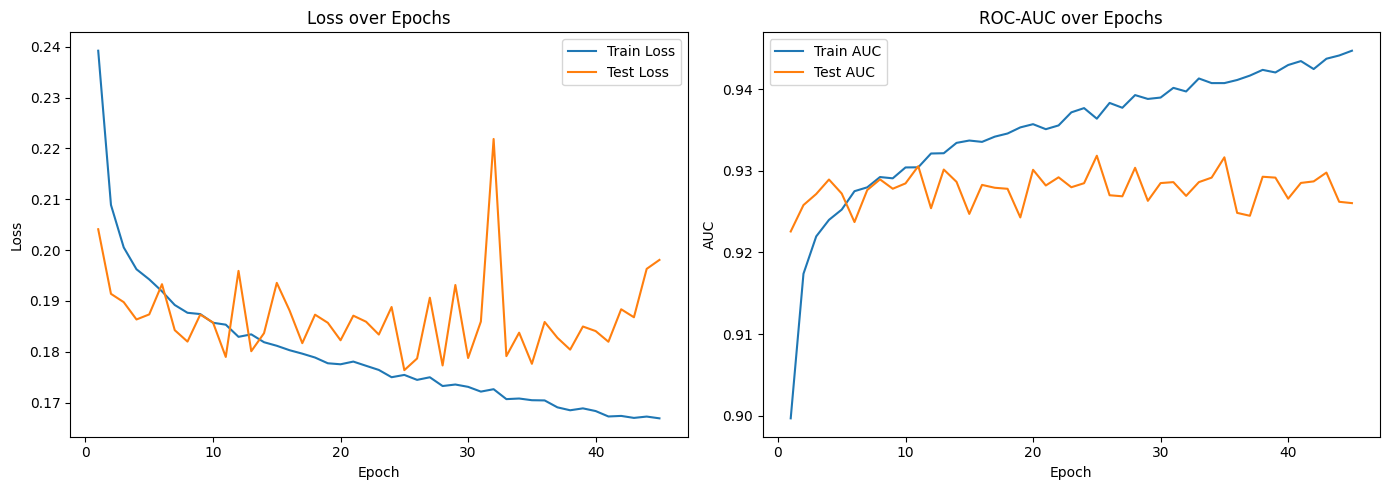

In [29]:
model = SkipMLP(
    embedding_sizes=embedding_sizes,
    num_input_dim=X_train_num.shape[1],
    hidden_size=128,
    num_blocks=3,
    emb_dim=4
)

trainer = Trainer(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    learning_rate=0.01,
    weight_decay=0.0,
    epochs=45,
)

trainer.train()
trainer.plot_metrics(filename_prefix="experiment_3")

In [32]:
experiment_3 = {
    'test_aucs': trainer.test_aucs,
    'train_aucs': trainer.train_aucs,
    'test_losses': trainer.test_losses,
    'train_losses': trainer.train_losses,
    'label': "exp3"
    }
save_experiment_to_csv(experiment_3, 'experiment_3.csv')
experiment_3

Эксперимент сохранён в experiment_3.csv


{'test_aucs': [np.float64(0.9225730646063737),
  np.float64(0.9258054070784872),
  np.float64(0.927163009964167),
  np.float64(0.9289337031702003),
  np.float64(0.927215152200569),
  np.float64(0.9237270984869229),
  np.float64(0.927648956560041),
  np.float64(0.9289523934238878),
  np.float64(0.9278065737312653),
  np.float64(0.9284597802407114),
  np.float64(0.9305713027225866),
  np.float64(0.925420411661766),
  np.float64(0.9301548791085821),
  np.float64(0.9286498970250355),
  np.float64(0.9247216104570184),
  np.float64(0.928277044320901),
  np.float64(0.927924905655885),
  np.float64(0.927799669051559),
  np.float64(0.9242918536684087),
  np.float64(0.9301260699277389),
  np.float64(0.9282051404149951),
  np.float64(0.9292067951572005),
  np.float64(0.92798895251247),
  np.float64(0.9284841847120868),
  np.float64(0.9318481922834253),
  np.float64(0.9270092022714016),
  np.float64(0.9268801561886169),
  np.float64(0.9303715431959143),
  np.float64(0.9263237342412589),
  np.float

✅ График сохранён как compare_2_to_3.png


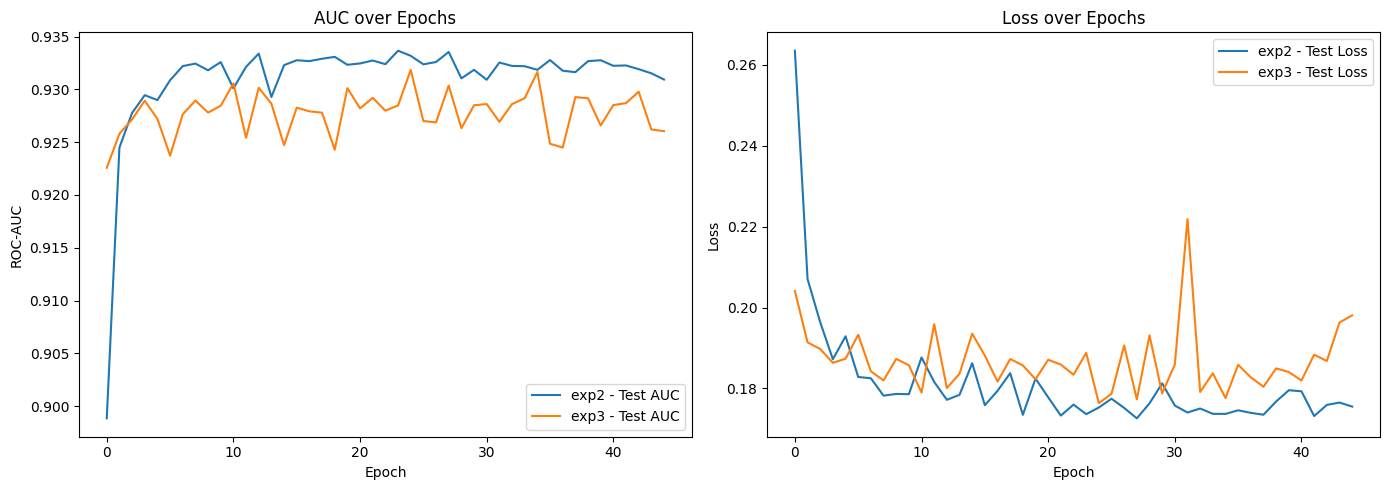

In [33]:
plot_all_experiments([experiment_2, experiment_3], 'test', 'compare_2_to_3')

In [37]:
print(max( enumerate(experiment_3["test_aucs"]), key = lambda x: x[1] ))
print(min( enumerate(experiment_3["test_losses"]), key = lambda x: x[1] ))

(24, np.float64(0.9318481922834253))
(24, 0.1763780228418869)


Выводы:

Skip Connections и Batch Norm не улучшили результат относительно 2 эксперимента. Вероятно это из-за того что такое усложнение модели делает её более чувствительной к batch_size и learning_rate, которые у нас могли быть выставлены не лучшим образом для такой модели.

Либо же ожидаемое улучшение результата могло бы сработать для модели с большим количеством слоёв. Точно сказать сложно.

Embedding-и немного улучшили результат, но всё ещё в этой модели почти моментально происходит переобучение и минмимумы по loss достигаются засчёт случайности.

* Минимальный loss: 0.1764
* Максимальный AUC: 0.9318


## Эксперимент 4

In [10]:
class DropoutBlock(nn.Module):
    def __init__(self, hidden_size, dropout_rate=0.1):
        super(DropoutBlock, self).__init__()
        self.norm = nn.BatchNorm1d(hidden_size)
        self.linear1 = nn.Linear(hidden_size, hidden_size * 4)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.linear2 = nn.Linear(hidden_size * 4, hidden_size)

    def forward(self, x):
        residual = x
        out = self.norm(x)
        out = self.linear1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.linear2(out)
        return out + residual

class DropoutMLP(nn.Module):
    def __init__(self, embedding_sizes, num_input_dim, hidden_size=128, num_blocks=3, dropout_rate=0.1, emb_dim=4):
        super(DropoutMLP, self).__init__()
        self.embeddings = nn.ModuleList([
            nn.Embedding(num_categories, emb_dim)
            for num_categories in embedding_sizes.values()
        ])

        total_emb_dim = emb_dim * len(embedding_sizes)
        input_dim = total_emb_dim + num_input_dim

        self.input_layer = nn.Linear(input_dim, hidden_size)
        self.blocks = nn.Sequential(
            *[DropoutBlock(hidden_size, dropout_rate) for _ in range(num_blocks)]
        )
        self.output_layer = nn.Linear(hidden_size, 1)

    def forward(self, x_cat, x_num):
        x_emb = [emb_layer(x_cat[:, i]) for i, emb_layer in enumerate(self.embeddings)]
        x_emb = torch.cat(x_emb, dim=1)
        x = torch.cat([x_emb, x_num], dim=1)
        x = self.input_layer(x)
        x = self.blocks(x)
        x = self.output_layer(x)
        return x


Запуск модели с dropout = 0.01
Epoch 1/35 | Train Loss: 0.2330, AUC: 0.9018 | Test Loss: 0.1979, AUC: 0.9242
Epoch 2/35 | Train Loss: 0.2059, AUC: 0.9187 | Test Loss: 0.1976, AUC: 0.9281
Epoch 3/35 | Train Loss: 0.2005, AUC: 0.9212 | Test Loss: 0.1894, AUC: 0.9283
Epoch 4/35 | Train Loss: 0.1964, AUC: 0.9238 | Test Loss: 0.1855, AUC: 0.9298
Epoch 5/35 | Train Loss: 0.1937, AUC: 0.9255 | Test Loss: 0.1843, AUC: 0.9297
Epoch 6/35 | Train Loss: 0.1920, AUC: 0.9264 | Test Loss: 0.1805, AUC: 0.9316
Epoch 7/35 | Train Loss: 0.1906, AUC: 0.9269 | Test Loss: 0.1834, AUC: 0.9295
Epoch 8/35 | Train Loss: 0.1886, AUC: 0.9284 | Test Loss: 0.1796, AUC: 0.9333
Epoch 9/35 | Train Loss: 0.1864, AUC: 0.9303 | Test Loss: 0.1828, AUC: 0.9290
Epoch 10/35 | Train Loss: 0.1856, AUC: 0.9303 | Test Loss: 0.1803, AUC: 0.9300
Epoch 11/35 | Train Loss: 0.1845, AUC: 0.9310 | Test Loss: 0.1837, AUC: 0.9312
Epoch 12/35 | Train Loss: 0.1835, AUC: 0.9316 | Test Loss: 0.1848, AUC: 0.9276
Epoch 13/35 | Train Loss: 0.1

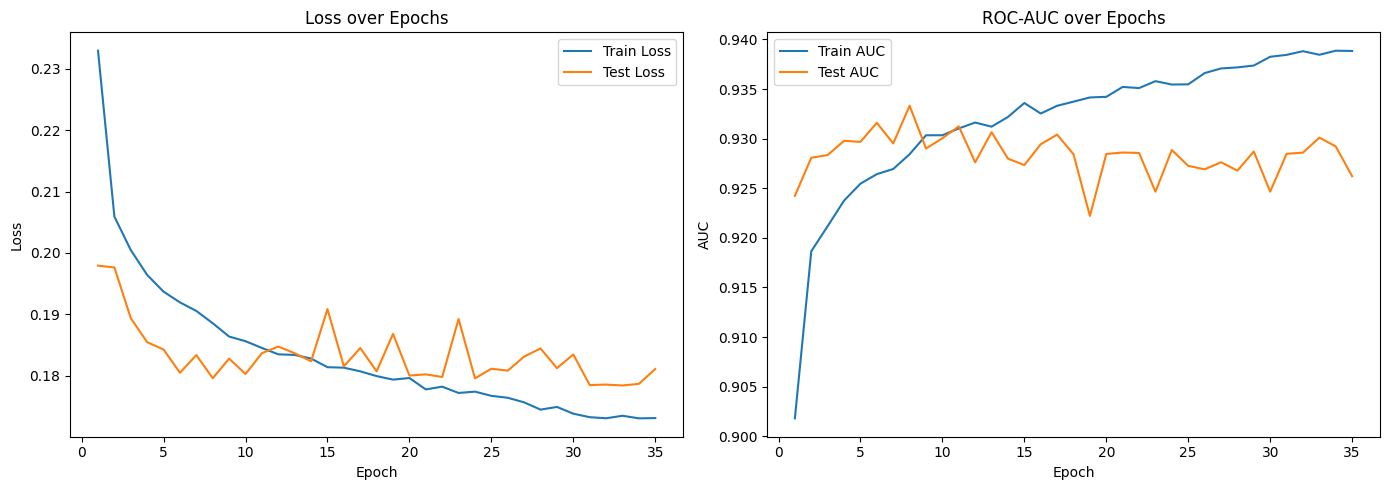

Эксперимент сохранён в experiment_4_dropout_0.01.csv

Запуск модели с dropout = 0.1
Epoch 1/35 | Train Loss: 0.2375, AUC: 0.8982 | Test Loss: 0.1966, AUC: 0.9264
Epoch 2/35 | Train Loss: 0.2085, AUC: 0.9178 | Test Loss: 0.1913, AUC: 0.9282
Epoch 3/35 | Train Loss: 0.2023, AUC: 0.9211 | Test Loss: 0.1887, AUC: 0.9296
Epoch 4/35 | Train Loss: 0.1974, AUC: 0.9240 | Test Loss: 0.1872, AUC: 0.9289
Epoch 5/35 | Train Loss: 0.1956, AUC: 0.9240 | Test Loss: 0.1872, AUC: 0.9296
Epoch 6/35 | Train Loss: 0.1928, AUC: 0.9265 | Test Loss: 0.1850, AUC: 0.9289
Epoch 7/35 | Train Loss: 0.1922, AUC: 0.9258 | Test Loss: 0.1833, AUC: 0.9299
Epoch 8/35 | Train Loss: 0.1901, AUC: 0.9272 | Test Loss: 0.1826, AUC: 0.9306
Epoch 9/35 | Train Loss: 0.1894, AUC: 0.9278 | Test Loss: 0.1787, AUC: 0.9308
Epoch 10/35 | Train Loss: 0.1887, AUC: 0.9277 | Test Loss: 0.1804, AUC: 0.9298
Epoch 11/35 | Train Loss: 0.1880, AUC: 0.9286 | Test Loss: 0.1798, AUC: 0.9303
Epoch 12/35 | Train Loss: 0.1870, AUC: 0.9293 | Test Los

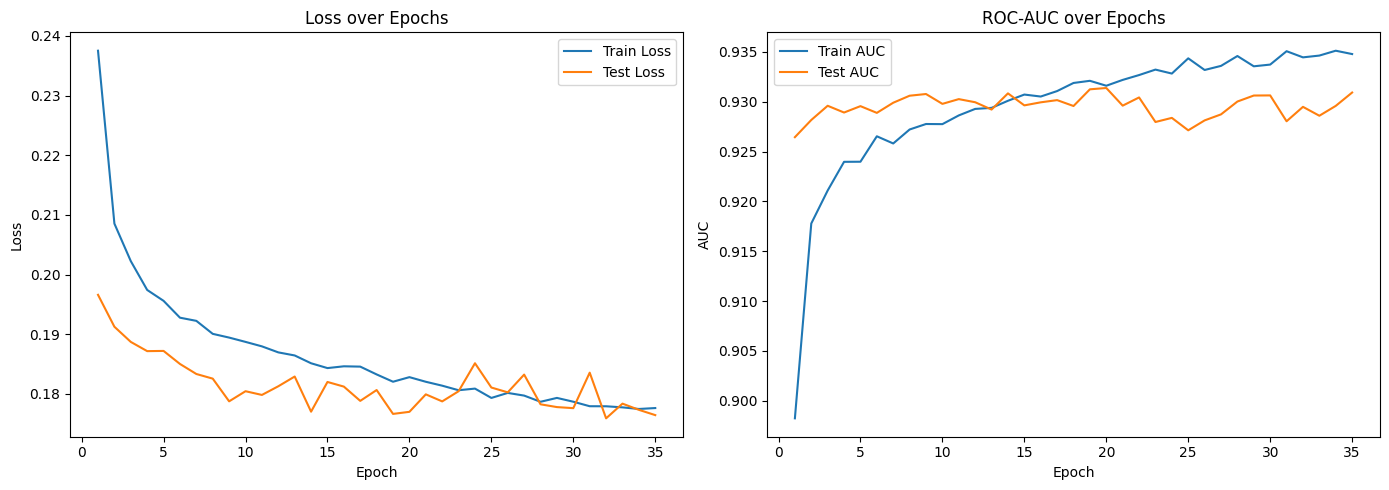

Эксперимент сохранён в experiment_4_dropout_0.1.csv

Запуск модели с dropout = 0.2
Epoch 1/35 | Train Loss: 0.2467, AUC: 0.8937 | Test Loss: 0.2083, AUC: 0.9180
Epoch 2/35 | Train Loss: 0.2186, AUC: 0.9116 | Test Loss: 0.2011, AUC: 0.9225
Epoch 3/35 | Train Loss: 0.2124, AUC: 0.9146 | Test Loss: 0.2043, AUC: 0.9240
Epoch 4/35 | Train Loss: 0.2048, AUC: 0.9195 | Test Loss: 0.1909, AUC: 0.9261
Epoch 5/35 | Train Loss: 0.2019, AUC: 0.9206 | Test Loss: 0.1946, AUC: 0.9257
Epoch 6/35 | Train Loss: 0.1986, AUC: 0.9223 | Test Loss: 0.1962, AUC: 0.9251
Epoch 7/35 | Train Loss: 0.1963, AUC: 0.9231 | Test Loss: 0.1892, AUC: 0.9263
Epoch 8/35 | Train Loss: 0.1958, AUC: 0.9240 | Test Loss: 0.1888, AUC: 0.9253
Epoch 9/35 | Train Loss: 0.1938, AUC: 0.9241 | Test Loss: 0.1850, AUC: 0.9272
Epoch 10/35 | Train Loss: 0.1924, AUC: 0.9262 | Test Loss: 0.1832, AUC: 0.9287
Epoch 11/35 | Train Loss: 0.1922, AUC: 0.9252 | Test Loss: 0.1852, AUC: 0.9276
Epoch 12/35 | Train Loss: 0.1904, AUC: 0.9265 | Test Loss

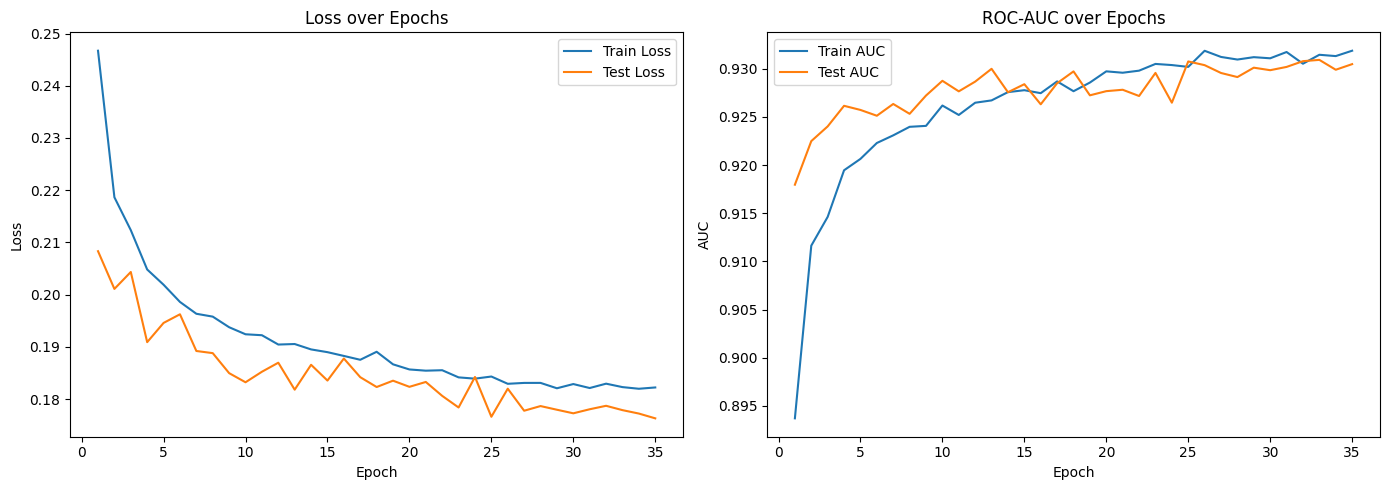

Эксперимент сохранён в experiment_4_dropout_0.2.csv

Запуск модели с dropout = 0.5
Epoch 1/35 | Train Loss: 0.2504, AUC: 0.8914 | Test Loss: 0.2047, AUC: 0.9246
Epoch 2/35 | Train Loss: 0.2261, AUC: 0.9086 | Test Loss: 0.2012, AUC: 0.9247
Epoch 3/35 | Train Loss: 0.2199, AUC: 0.9126 | Test Loss: 0.1962, AUC: 0.9276
Epoch 4/35 | Train Loss: 0.2156, AUC: 0.9140 | Test Loss: 0.1967, AUC: 0.9286
Epoch 5/35 | Train Loss: 0.2104, AUC: 0.9169 | Test Loss: 0.1898, AUC: 0.9295
Epoch 6/35 | Train Loss: 0.2075, AUC: 0.9180 | Test Loss: 0.1872, AUC: 0.9301
Epoch 7/35 | Train Loss: 0.2053, AUC: 0.9195 | Test Loss: 0.1842, AUC: 0.9308
Epoch 8/35 | Train Loss: 0.2039, AUC: 0.9198 | Test Loss: 0.1844, AUC: 0.9301
Epoch 9/35 | Train Loss: 0.2016, AUC: 0.9206 | Test Loss: 0.1834, AUC: 0.9314
Epoch 10/35 | Train Loss: 0.1983, AUC: 0.9230 | Test Loss: 0.1846, AUC: 0.9302
Epoch 11/35 | Train Loss: 0.1984, AUC: 0.9225 | Test Loss: 0.1851, AUC: 0.9297
Epoch 12/35 | Train Loss: 0.1967, AUC: 0.9233 | Test Loss

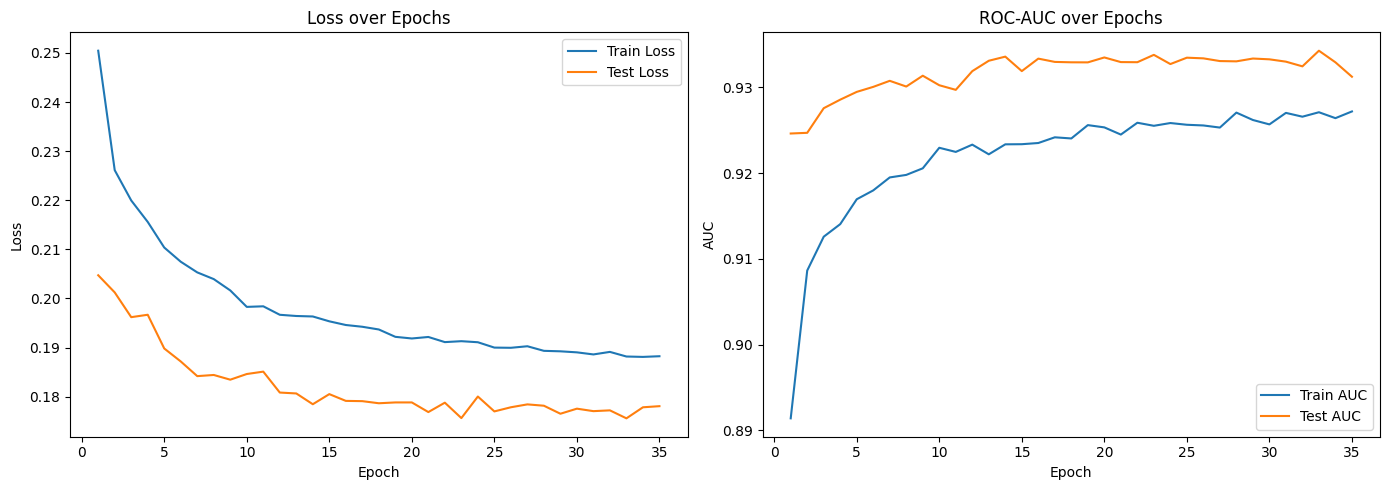

Эксперимент сохранён в experiment_4_dropout_0.5.csv

Запуск модели с dropout = 0.9
Epoch 1/35 | Train Loss: 0.2963, AUC: 0.8484 | Test Loss: 0.2354, AUC: 0.9084
Epoch 2/35 | Train Loss: 0.2587, AUC: 0.8856 | Test Loss: 0.2247, AUC: 0.9153
Epoch 3/35 | Train Loss: 0.2513, AUC: 0.8924 | Test Loss: 0.2204, AUC: 0.9167
Epoch 4/35 | Train Loss: 0.2446, AUC: 0.8968 | Test Loss: 0.2156, AUC: 0.9194
Epoch 5/35 | Train Loss: 0.2429, AUC: 0.8982 | Test Loss: 0.2118, AUC: 0.9210
Epoch 6/35 | Train Loss: 0.2372, AUC: 0.9021 | Test Loss: 0.2110, AUC: 0.9228
Epoch 7/35 | Train Loss: 0.2369, AUC: 0.9006 | Test Loss: 0.2086, AUC: 0.9232
Epoch 8/35 | Train Loss: 0.2343, AUC: 0.9030 | Test Loss: 0.2057, AUC: 0.9245
Epoch 9/35 | Train Loss: 0.2321, AUC: 0.9038 | Test Loss: 0.2055, AUC: 0.9254
Epoch 10/35 | Train Loss: 0.2302, AUC: 0.9053 | Test Loss: 0.2039, AUC: 0.9250
Epoch 11/35 | Train Loss: 0.2271, AUC: 0.9073 | Test Loss: 0.2056, AUC: 0.9260
Epoch 12/35 | Train Loss: 0.2275, AUC: 0.9066 | Test Loss

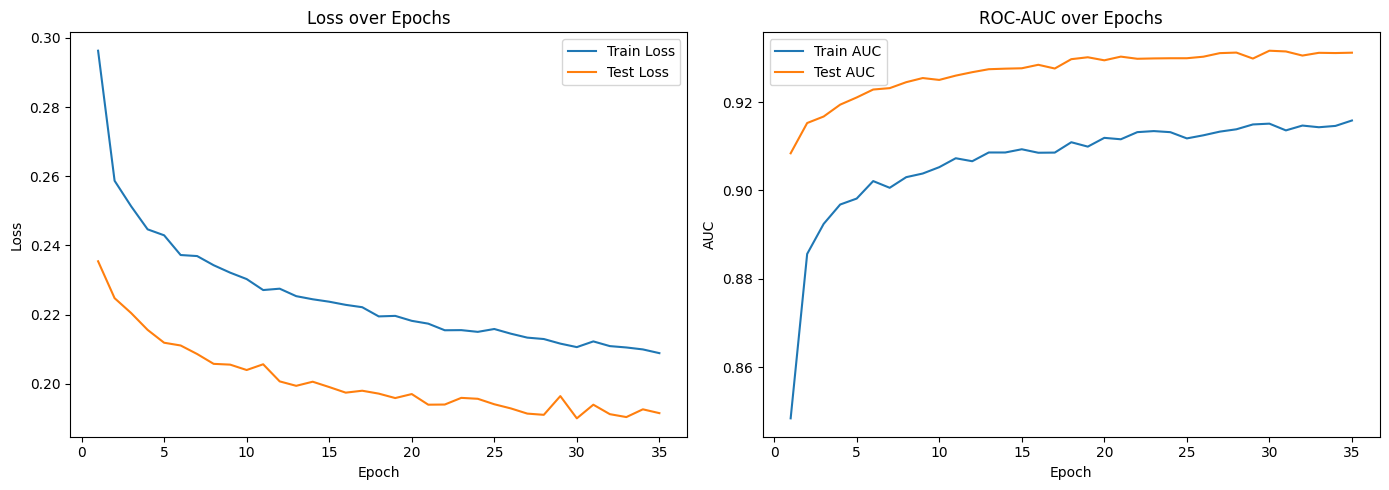

Эксперимент сохранён в experiment_4_dropout_0.9.csv


In [8]:
dropout_rates = [0.01, 0.1, 0.2, 0.5, 0.9]
experiment_results = []

for p in dropout_rates:
    print(f"\nЗапуск модели с dropout = {p}")

    model = DropoutMLP(
        embedding_sizes=embedding_sizes,
        num_input_dim=X_train_num.shape[1],
        dropout_rate=p,
        hidden_size=128,
        num_blocks=3,
        emb_dim=4
    )

    trainer = Trainer(
        model=model,
        train_loader=train_loader,
        test_loader=test_loader,
        learning_rate=0.01,
        weight_decay=0.0,
        epochs=35,
        device='cuda'
    )

    trainer.train()
    prefix = f"experiment_4_dropout_{p}"

    trainer.plot_metrics(filename_prefix=prefix)

    experiment_dict = {
        'label': f'dropout_{p}',
        'train_losses': trainer.train_losses,
        'test_losses': trainer.test_losses,
        'train_aucs': trainer.train_aucs,
        'test_aucs': trainer.test_aucs
    }
    save_experiment_to_csv(experiment_dict, f"{prefix}.csv")
    experiment_results.append(experiment_dict)

In [9]:
# Находим лучший по финальному test AUC
best = max(experiment_results, key=lambda x: x['test_aucs'][-1])
print(f"\nЛучший dropout_rate: {best['label']} — Test AUC: {best['test_aucs'][-1]:.4f}")


Лучший dropout_rate: dropout_0.5 — Test AUC: 0.9312


In [10]:
experiment_results

[{'label': 'dropout_0.01',
  'train_losses': [0.2329507744020926,
   0.20592207310155922,
   0.20047538539323448,
   0.19642316607893212,
   0.19370018880321654,
   0.19195207507942788,
   0.19055692463627635,
   0.1885574041233003,
   0.18638764633717705,
   0.18563181372269758,
   0.18452977541270876,
   0.18349637733281857,
   0.1833917184094445,
   0.18280700549748685,
   0.18139792013999503,
   0.1813178444115354,
   0.18072392805682388,
   0.1799488648066425,
   0.1793739434070504,
   0.17963435966782654,
   0.1777773426253491,
   0.17822644205770288,
   0.17719993760929997,
   0.1774163308932773,
   0.176731840073046,
   0.17641676495634456,
   0.17566945165248926,
   0.174487001817305,
   0.1749241759980118,
   0.17382435818069042,
   0.1732535525800695,
   0.1730784420365861,
   0.17348570520451412,
   0.17306571464827505,
   0.17310666169529387],
  'test_losses': [0.19794011168874234,
   0.1976412955452414,
   0.1893791341212501,
   0.18546962302054285,
   0.18427049540497764

✅ График сохранён как compare_dropout.png


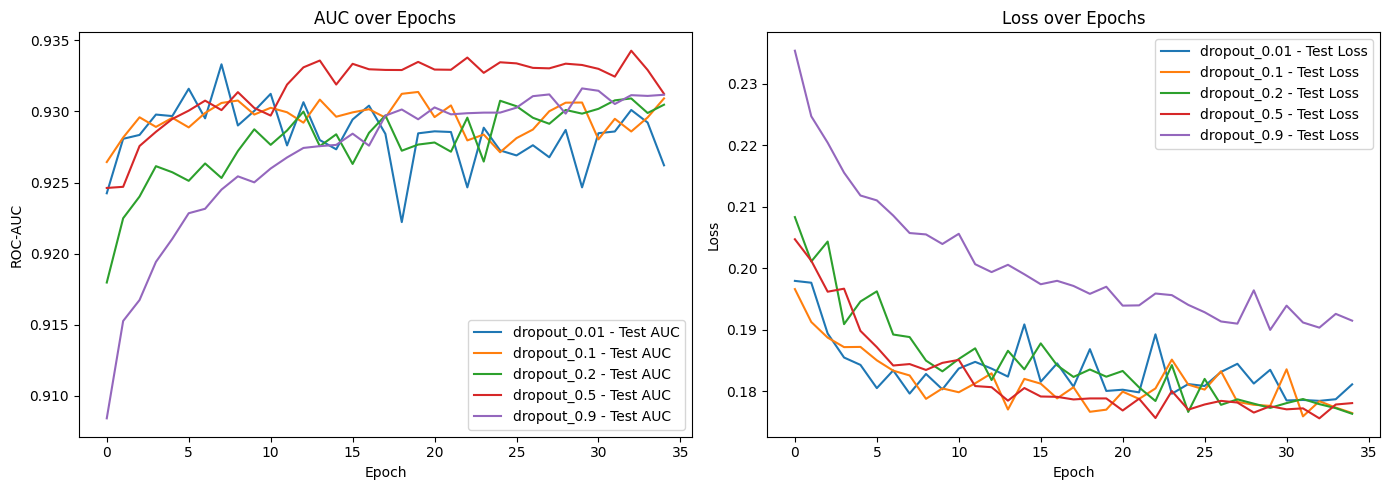

In [11]:
plot_all_experiments(experiment_results, 'test', 'compare_dropout')

Выводы:

Заметно улучшение относительно 3 эксперимента.
Наилучшая модель - dropout_rate = 0.5. До embedding-ов это было dropout_rate=0.1, однако результат изменился и теперь у нас 0.5 обучается заметно лучше, а признаки переобучения заметны на всех dropout_rate меньше 0.2.

Тем не менее модель всё ещё немного отстаёт от 2-го эксперимента по качеству.

Вероятно это всё ещё из-за неправильного learning_rate.

* Минимальный loss: 0.1755
* Максимальный AUC: 0.9312

## Эксперимент 5

In [11]:
learning_rates = [0.01, 0.05, 0.1]
weight_decays = [0.1, 0.01, 0.001]
dropout_rate = 0.5  # фиксируем dropout


Обучаем модель: lr=0.01, weight_decay=0.1
Epoch 1/35 | Train Loss: 0.3098, AUC: 0.8632 | Test Loss: 0.3129, AUC: 0.8810
Epoch 2/35 | Train Loss: 0.3227, AUC: 0.8648 | Test Loss: 0.3207, AUC: 0.8720
Epoch 3/35 | Train Loss: 0.3253, AUC: 0.8601 | Test Loss: 0.3204, AUC: 0.8715
Epoch 4/35 | Train Loss: 0.3252, AUC: 0.8596 | Test Loss: 0.3224, AUC: 0.8719
Epoch 5/35 | Train Loss: 0.3256, AUC: 0.8599 | Test Loss: 0.3208, AUC: 0.8701
Epoch 6/35 | Train Loss: 0.3253, AUC: 0.8594 | Test Loss: 0.3213, AUC: 0.8706
Epoch 7/35 | Train Loss: 0.3257, AUC: 0.8594 | Test Loss: 0.3197, AUC: 0.8711
Epoch 8/35 | Train Loss: 0.3252, AUC: 0.8596 | Test Loss: 0.3211, AUC: 0.8712
Epoch 9/35 | Train Loss: 0.3257, AUC: 0.8595 | Test Loss: 0.3195, AUC: 0.8707
Epoch 10/35 | Train Loss: 0.3251, AUC: 0.8594 | Test Loss: 0.3214, AUC: 0.8720
Epoch 11/35 | Train Loss: 0.3255, AUC: 0.8595 | Test Loss: 0.3209, AUC: 0.8723
Epoch 12/35 | Train Loss: 0.3254, AUC: 0.8598 | Test Loss: 0.3202, AUC: 0.8708
Epoch 13/35 | Trai

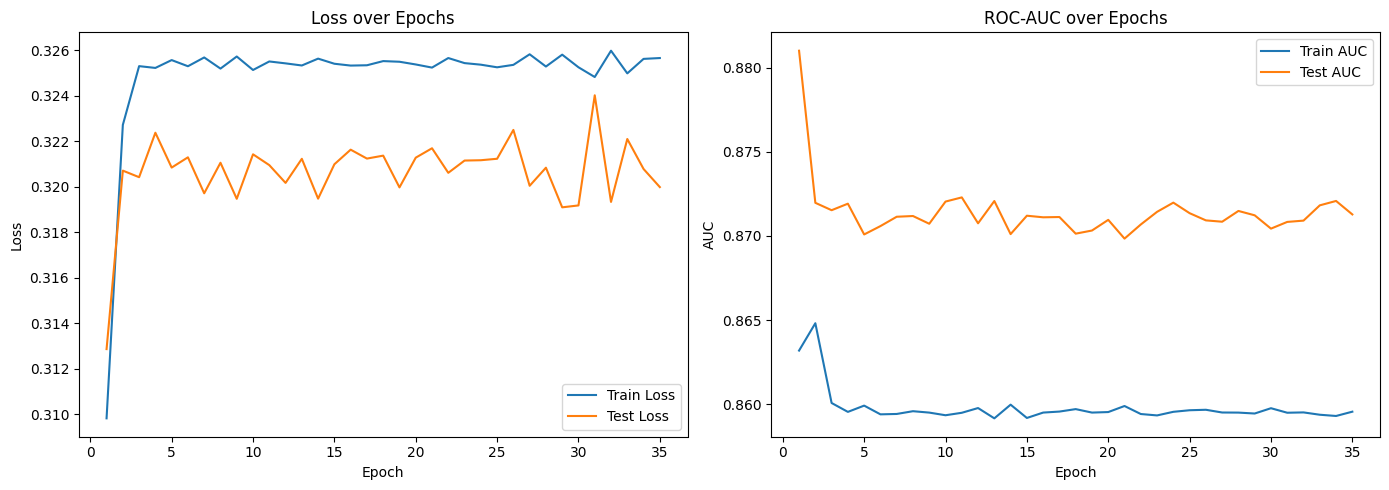

Эксперимент сохранён в experiment_5_lr_0.01_wd_0.1.csv

Обучаем модель: lr=0.01, weight_decay=0.01
Epoch 1/35 | Train Loss: 0.2463, AUC: 0.8951 | Test Loss: 0.2072, AUC: 0.9259
Epoch 2/35 | Train Loss: 0.2201, AUC: 0.9115 | Test Loss: 0.1999, AUC: 0.9284
Epoch 3/35 | Train Loss: 0.2137, AUC: 0.9162 | Test Loss: 0.1955, AUC: 0.9301
Epoch 4/35 | Train Loss: 0.2085, AUC: 0.9186 | Test Loss: 0.1965, AUC: 0.9297
Epoch 5/35 | Train Loss: 0.2082, AUC: 0.9186 | Test Loss: 0.1934, AUC: 0.9292
Epoch 6/35 | Train Loss: 0.2063, AUC: 0.9199 | Test Loss: 0.1979, AUC: 0.9310
Epoch 7/35 | Train Loss: 0.2062, AUC: 0.9196 | Test Loss: 0.1900, AUC: 0.9293
Epoch 8/35 | Train Loss: 0.2048, AUC: 0.9196 | Test Loss: 0.1920, AUC: 0.9297
Epoch 9/35 | Train Loss: 0.2050, AUC: 0.9199 | Test Loss: 0.1906, AUC: 0.9299
Epoch 10/35 | Train Loss: 0.2071, AUC: 0.9192 | Test Loss: 0.1990, AUC: 0.9281
Epoch 11/35 | Train Loss: 0.2069, AUC: 0.9179 | Test Loss: 0.1924, AUC: 0.9270
Epoch 12/35 | Train Loss: 0.2071, AUC: 0.

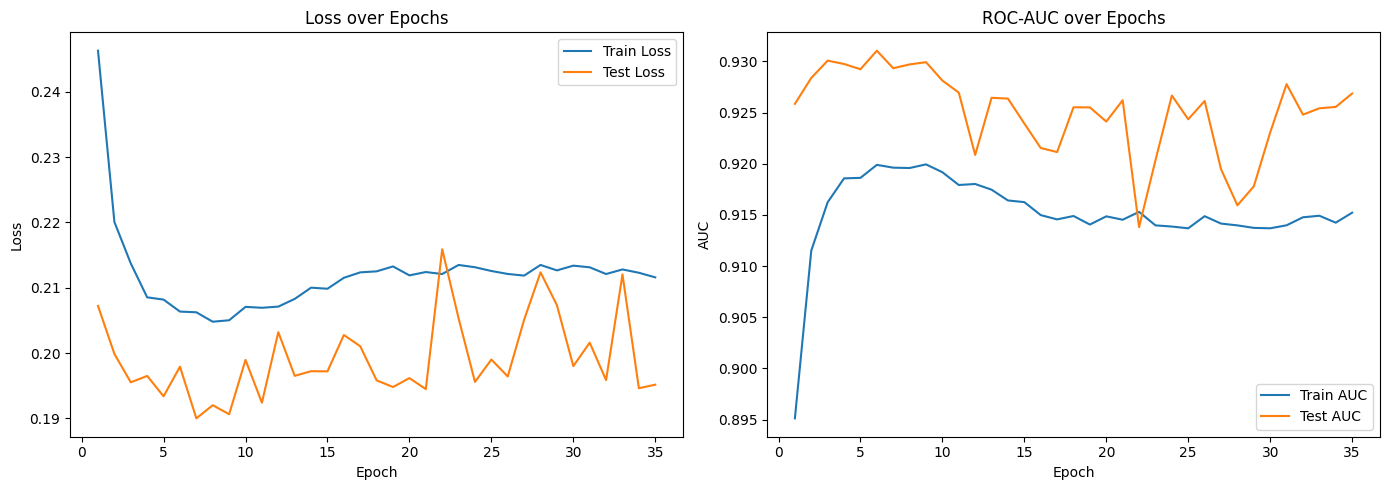

Эксперимент сохранён в experiment_5_lr_0.01_wd_0.01.csv

Обучаем модель: lr=0.01, weight_decay=0.001
Epoch 1/35 | Train Loss: 0.2523, AUC: 0.8906 | Test Loss: 0.2099, AUC: 0.9213
Epoch 2/35 | Train Loss: 0.2243, AUC: 0.9089 | Test Loss: 0.1998, AUC: 0.9256
Epoch 3/35 | Train Loss: 0.2189, AUC: 0.9114 | Test Loss: 0.1952, AUC: 0.9279
Epoch 4/35 | Train Loss: 0.2129, AUC: 0.9161 | Test Loss: 0.1917, AUC: 0.9296
Epoch 5/35 | Train Loss: 0.2092, AUC: 0.9165 | Test Loss: 0.1886, AUC: 0.9302
Epoch 6/35 | Train Loss: 0.2066, AUC: 0.9175 | Test Loss: 0.1887, AUC: 0.9314
Epoch 7/35 | Train Loss: 0.2037, AUC: 0.9194 | Test Loss: 0.1843, AUC: 0.9318
Epoch 8/35 | Train Loss: 0.2024, AUC: 0.9205 | Test Loss: 0.1844, AUC: 0.9322
Epoch 9/35 | Train Loss: 0.2006, AUC: 0.9214 | Test Loss: 0.1831, AUC: 0.9325
Epoch 10/35 | Train Loss: 0.1974, AUC: 0.9231 | Test Loss: 0.1826, AUC: 0.9322
Epoch 11/35 | Train Loss: 0.1981, AUC: 0.9222 | Test Loss: 0.1818, AUC: 0.9329
Epoch 12/35 | Train Loss: 0.1963, AUC: 

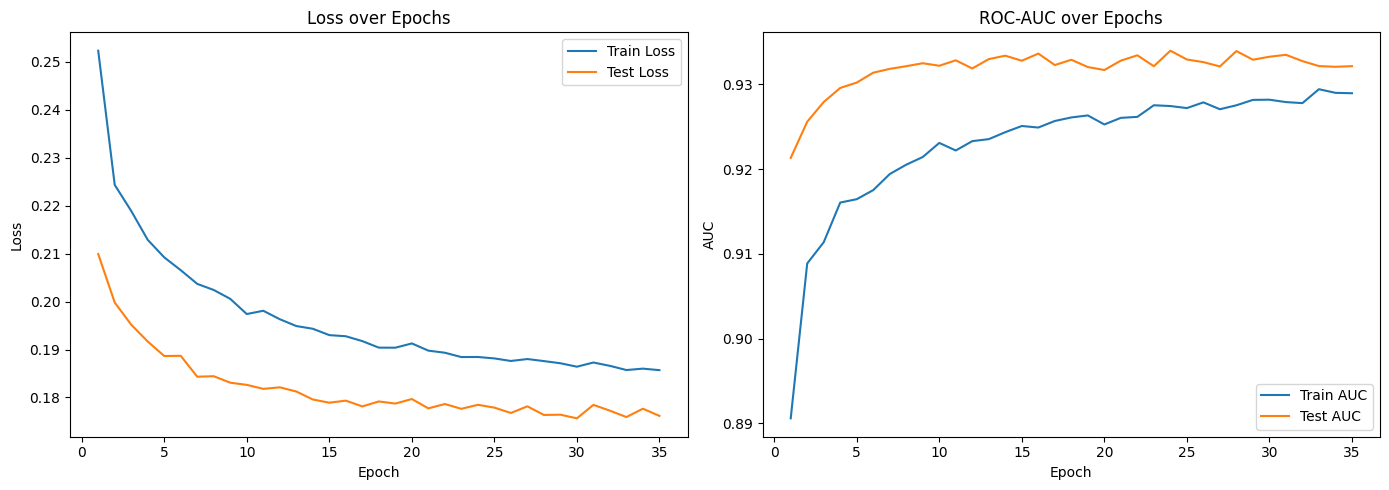

Эксперимент сохранён в experiment_5_lr_0.01_wd_0.001.csv

Обучаем модель: lr=0.05, weight_decay=0.1
Epoch 1/35 | Train Loss: 0.3216, AUC: 0.8603 | Test Loss: 0.3154, AUC: 0.8699
Epoch 2/35 | Train Loss: 0.3257, AUC: 0.8581 | Test Loss: 0.3241, AUC: 0.8723
Epoch 3/35 | Train Loss: 0.3258, AUC: 0.8584 | Test Loss: 0.3200, AUC: 0.8728
Epoch 4/35 | Train Loss: 0.3257, AUC: 0.8585 | Test Loss: 0.3201, AUC: 0.8692
Epoch 5/35 | Train Loss: 0.3259, AUC: 0.8580 | Test Loss: 0.3208, AUC: 0.8731
Epoch 6/35 | Train Loss: 0.3255, AUC: 0.8588 | Test Loss: 0.3245, AUC: 0.8721
Epoch 7/35 | Train Loss: 0.3260, AUC: 0.8584 | Test Loss: 0.3176, AUC: 0.8701
Epoch 8/35 | Train Loss: 0.3256, AUC: 0.8584 | Test Loss: 0.3232, AUC: 0.8717
Epoch 9/35 | Train Loss: 0.3258, AUC: 0.8582 | Test Loss: 0.3228, AUC: 0.8724
Epoch 10/35 | Train Loss: 0.3257, AUC: 0.8587 | Test Loss: 0.3235, AUC: 0.8746
Epoch 11/35 | Train Loss: 0.3257, AUC: 0.8584 | Test Loss: 0.3243, AUC: 0.8692
Epoch 12/35 | Train Loss: 0.3258, AUC: 0

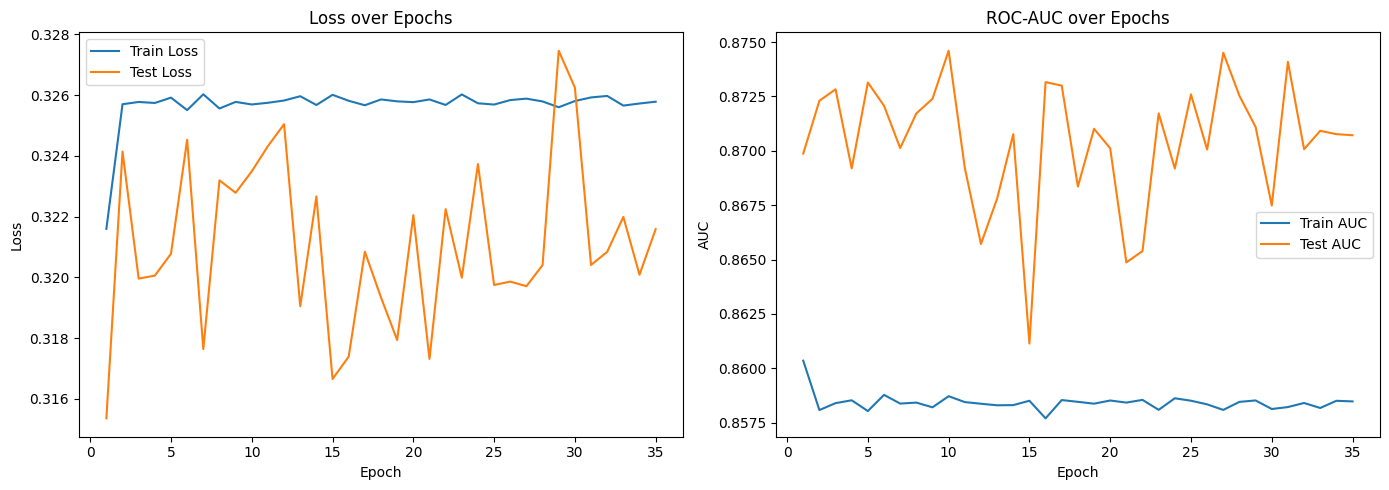

Эксперимент сохранён в experiment_5_lr_0.05_wd_0.1.csv

Обучаем модель: lr=0.05, weight_decay=0.01
Epoch 1/35 | Train Loss: 0.2340, AUC: 0.9022 | Test Loss: 0.2224, AUC: 0.9211
Epoch 2/35 | Train Loss: 0.2193, AUC: 0.9115 | Test Loss: 0.2108, AUC: 0.9242
Epoch 3/35 | Train Loss: 0.2229, AUC: 0.9093 | Test Loss: 0.2091, AUC: 0.9220
Epoch 4/35 | Train Loss: 0.2265, AUC: 0.9073 | Test Loss: 0.2333, AUC: 0.9182
Epoch 5/35 | Train Loss: 0.2276, AUC: 0.9062 | Test Loss: 0.2133, AUC: 0.9203
Epoch 6/35 | Train Loss: 0.2276, AUC: 0.9069 | Test Loss: 0.2328, AUC: 0.9137
Epoch 7/35 | Train Loss: 0.2287, AUC: 0.9060 | Test Loss: 0.2195, AUC: 0.9167
Epoch 8/35 | Train Loss: 0.2271, AUC: 0.9069 | Test Loss: 0.2154, AUC: 0.9195
Epoch 9/35 | Train Loss: 0.2272, AUC: 0.9063 | Test Loss: 0.2206, AUC: 0.9155
Epoch 10/35 | Train Loss: 0.2269, AUC: 0.9071 | Test Loss: 0.2147, AUC: 0.9177
Epoch 11/35 | Train Loss: 0.2275, AUC: 0.9075 | Test Loss: 0.2119, AUC: 0.9188
Epoch 12/35 | Train Loss: 0.2281, AUC: 0.

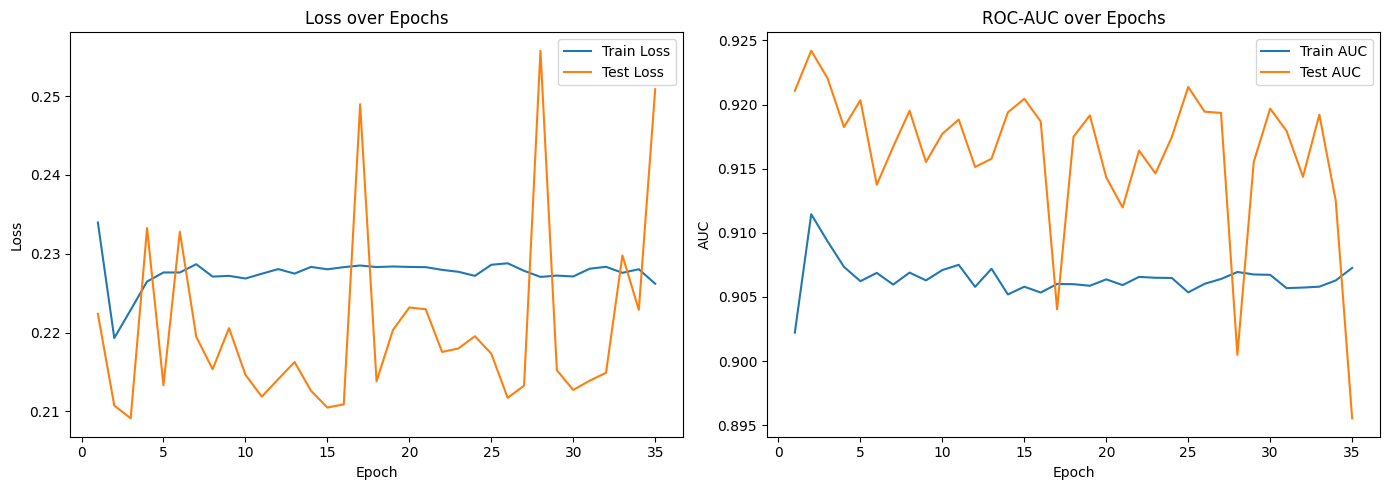

Эксперимент сохранён в experiment_5_lr_0.05_wd_0.01.csv

Обучаем модель: lr=0.05, weight_decay=0.001
Epoch 1/35 | Train Loss: 0.2344, AUC: 0.9008 | Test Loss: 0.2008, AUC: 0.9204
Epoch 2/35 | Train Loss: 0.2110, AUC: 0.9151 | Test Loss: 0.1947, AUC: 0.9241
Epoch 3/35 | Train Loss: 0.2048, AUC: 0.9178 | Test Loss: 0.1882, AUC: 0.9294
Epoch 4/35 | Train Loss: 0.2002, AUC: 0.9204 | Test Loss: 0.1832, AUC: 0.9302
Epoch 5/35 | Train Loss: 0.1972, AUC: 0.9215 | Test Loss: 0.1889, AUC: 0.9321
Epoch 6/35 | Train Loss: 0.1941, AUC: 0.9238 | Test Loss: 0.1813, AUC: 0.9299
Epoch 7/35 | Train Loss: 0.1943, AUC: 0.9231 | Test Loss: 0.1797, AUC: 0.9316
Epoch 8/35 | Train Loss: 0.1922, AUC: 0.9241 | Test Loss: 0.1861, AUC: 0.9315
Epoch 9/35 | Train Loss: 0.1913, AUC: 0.9255 | Test Loss: 0.1805, AUC: 0.9312
Epoch 10/35 | Train Loss: 0.1901, AUC: 0.9267 | Test Loss: 0.1898, AUC: 0.9296
Epoch 11/35 | Train Loss: 0.1903, AUC: 0.9250 | Test Loss: 0.1790, AUC: 0.9332
Epoch 12/35 | Train Loss: 0.1903, AUC: 

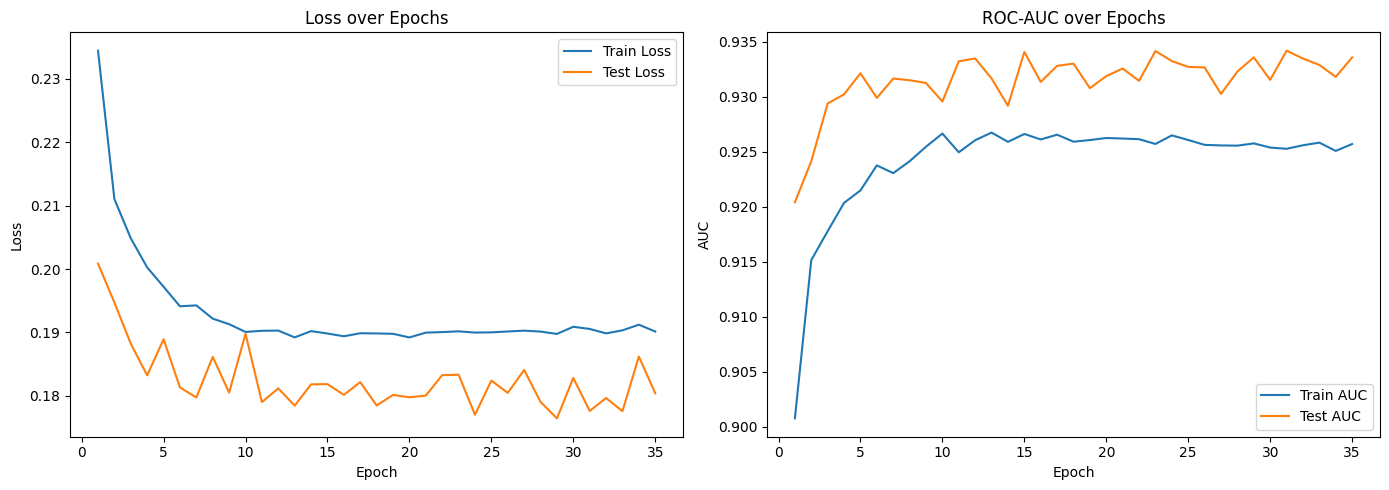

Эксперимент сохранён в experiment_5_lr_0.05_wd_0.001.csv

Обучаем модель: lr=0.1, weight_decay=0.1
Epoch 1/35 | Train Loss: 0.3233, AUC: 0.8586 | Test Loss: 0.3217, AUC: 0.8673
Epoch 2/35 | Train Loss: 0.3262, AUC: 0.8571 | Test Loss: 0.3202, AUC: 0.8724
Epoch 3/35 | Train Loss: 0.3264, AUC: 0.8568 | Test Loss: 0.3168, AUC: 0.8689
Epoch 4/35 | Train Loss: 0.3263, AUC: 0.8568 | Test Loss: 0.3304, AUC: 0.8716
Epoch 5/35 | Train Loss: 0.3265, AUC: 0.8564 | Test Loss: 0.3196, AUC: 0.8736
Epoch 6/35 | Train Loss: 0.3261, AUC: 0.8569 | Test Loss: 0.3279, AUC: 0.8741
Epoch 7/35 | Train Loss: 0.3266, AUC: 0.8569 | Test Loss: 0.3169, AUC: 0.8683
Epoch 8/35 | Train Loss: 0.3261, AUC: 0.8568 | Test Loss: 0.3178, AUC: 0.8625
Epoch 9/35 | Train Loss: 0.3263, AUC: 0.8567 | Test Loss: 0.3257, AUC: 0.8688
Epoch 10/35 | Train Loss: 0.3264, AUC: 0.8564 | Test Loss: 0.3250, AUC: 0.8773
Epoch 11/35 | Train Loss: 0.3262, AUC: 0.8572 | Test Loss: 0.3222, AUC: 0.8698
Epoch 12/35 | Train Loss: 0.3261, AUC: 0.

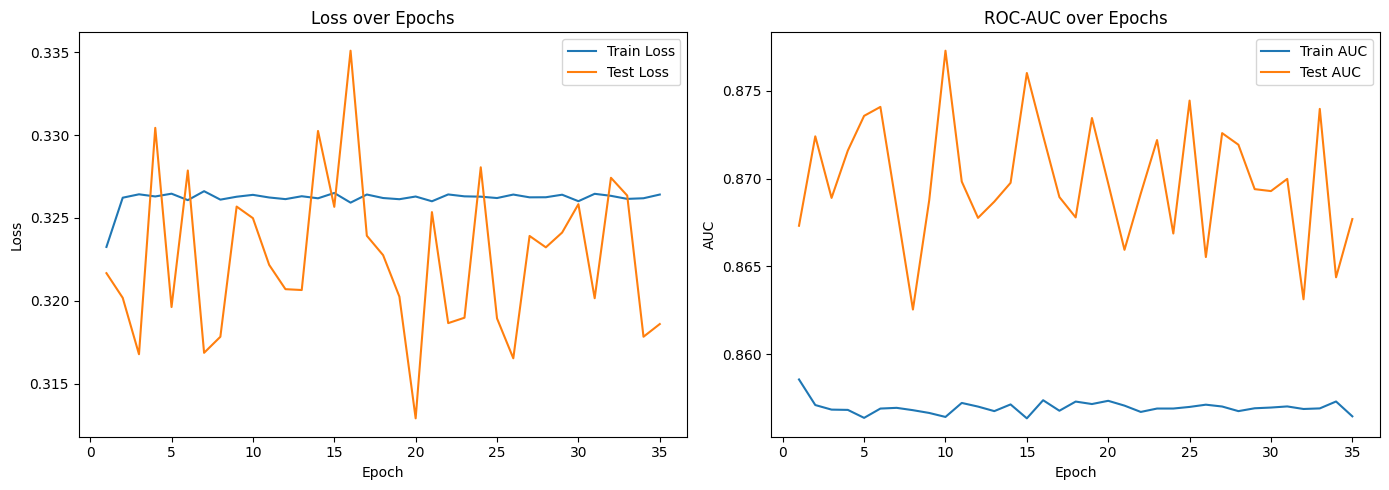

Эксперимент сохранён в experiment_5_lr_0.1_wd_0.1.csv

Обучаем модель: lr=0.1, weight_decay=0.01
Epoch 1/35 | Train Loss: 0.2351, AUC: 0.9020 | Test Loss: 0.2178, AUC: 0.9196
Epoch 2/35 | Train Loss: 0.2303, AUC: 0.9056 | Test Loss: 0.2244, AUC: 0.9155
Epoch 3/35 | Train Loss: 0.2355, AUC: 0.9023 | Test Loss: 0.2230, AUC: 0.9154
Epoch 4/35 | Train Loss: 0.2368, AUC: 0.9011 | Test Loss: 0.2253, AUC: 0.9128
Epoch 5/35 | Train Loss: 0.2379, AUC: 0.9015 | Test Loss: 0.2537, AUC: 0.9062
Epoch 6/35 | Train Loss: 0.2380, AUC: 0.9017 | Test Loss: 0.2308, AUC: 0.9115
Epoch 7/35 | Train Loss: 0.2388, AUC: 0.9007 | Test Loss: 0.2288, AUC: 0.9103
Epoch 8/35 | Train Loss: 0.2378, AUC: 0.9020 | Test Loss: 0.2257, AUC: 0.9112
Epoch 9/35 | Train Loss: 0.2371, AUC: 0.9021 | Test Loss: 0.2205, AUC: 0.9144
Epoch 10/35 | Train Loss: 0.2383, AUC: 0.9008 | Test Loss: 0.2323, AUC: 0.9090
Epoch 11/35 | Train Loss: 0.2370, AUC: 0.9021 | Test Loss: 0.2393, AUC: 0.9083
Epoch 12/35 | Train Loss: 0.2383, AUC: 0.90

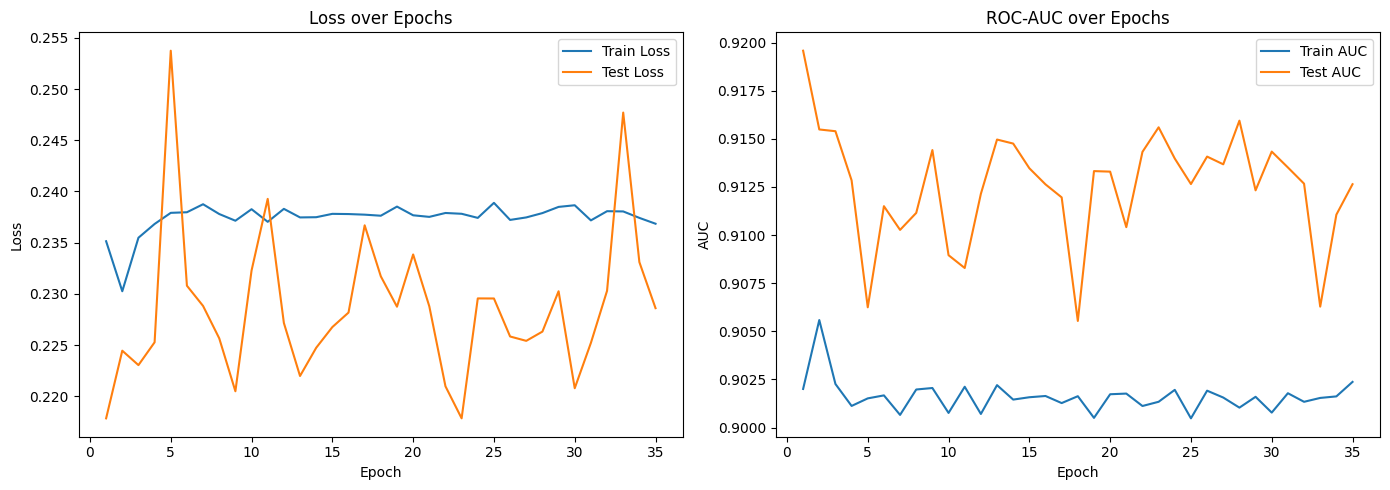

Эксперимент сохранён в experiment_5_lr_0.1_wd_0.01.csv

Обучаем модель: lr=0.1, weight_decay=0.001
Epoch 1/35 | Train Loss: 0.2387, AUC: 0.8975 | Test Loss: 0.1958, AUC: 0.9245
Epoch 2/35 | Train Loss: 0.2093, AUC: 0.9141 | Test Loss: 0.1839, AUC: 0.9303
Epoch 3/35 | Train Loss: 0.2013, AUC: 0.9194 | Test Loss: 0.1895, AUC: 0.9284
Epoch 4/35 | Train Loss: 0.1985, AUC: 0.9199 | Test Loss: 0.1806, AUC: 0.9299
Epoch 5/35 | Train Loss: 0.1967, AUC: 0.9217 | Test Loss: 0.1841, AUC: 0.9303
Epoch 6/35 | Train Loss: 0.1962, AUC: 0.9215 | Test Loss: 0.1940, AUC: 0.9289
Epoch 7/35 | Train Loss: 0.1949, AUC: 0.9228 | Test Loss: 0.1897, AUC: 0.9330
Epoch 8/35 | Train Loss: 0.1948, AUC: 0.9233 | Test Loss: 0.1822, AUC: 0.9312
Epoch 9/35 | Train Loss: 0.1945, AUC: 0.9230 | Test Loss: 0.1897, AUC: 0.9327
Epoch 10/35 | Train Loss: 0.1945, AUC: 0.9232 | Test Loss: 0.1853, AUC: 0.9322
Epoch 11/35 | Train Loss: 0.1945, AUC: 0.9236 | Test Loss: 0.1825, AUC: 0.9309
Epoch 12/35 | Train Loss: 0.1948, AUC: 0.

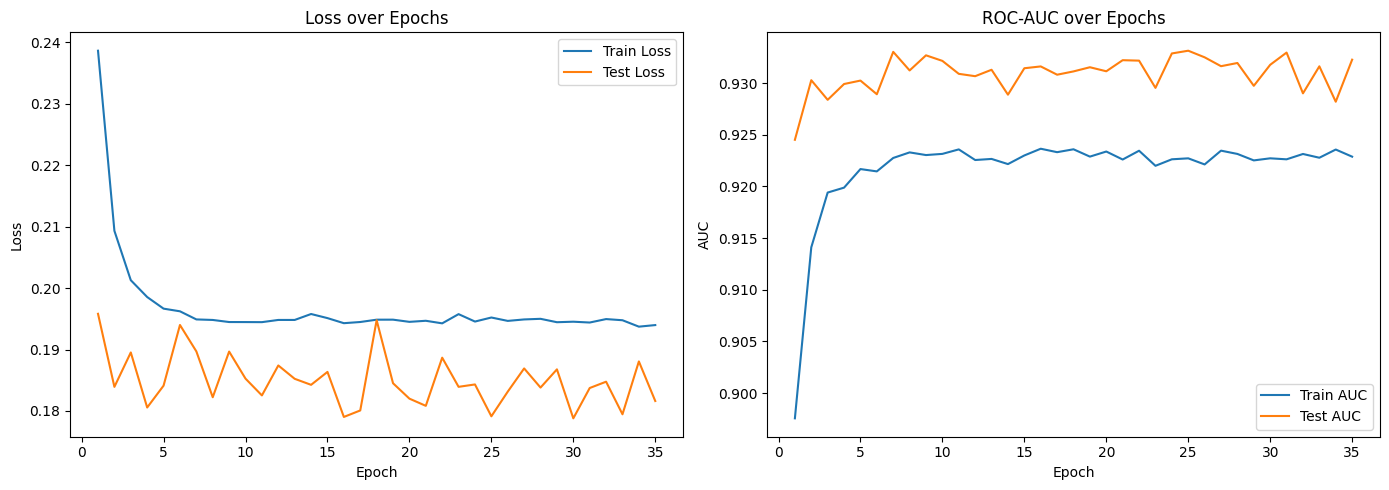

Эксперимент сохранён в experiment_5_lr_0.1_wd_0.001.csv


In [13]:
experiment_5_results = []

for lr in learning_rates:
    for wd in weight_decays:
        print(f"\nОбучаем модель: lr={lr}, weight_decay={wd}")

        model = DropoutMLP(
            embedding_sizes=embedding_sizes,
            num_input_dim=X_train_num.shape[1],
            dropout_rate=dropout_rate,
            hidden_size=128,
            num_blocks=3,
            emb_dim=4
        )

        trainer = Trainer(
            model=model,
            train_loader=train_loader,
            test_loader=test_loader,
            learning_rate=lr,
            weight_decay=wd,
            epochs=35,
            device='cuda'
        )

        trainer.train()
        prefix = f"experiment_5_lr_{lr}_wd_{wd}"

        trainer.plot_metrics(filename_prefix=prefix)

        experiment_dict = {
            'label': f'lr={lr}_wd={wd}',
            'train_losses': trainer.train_losses,
            'test_losses': trainer.test_losses,
            'train_aucs': trainer.train_aucs,
            'test_aucs': trainer.test_aucs
        }
        save_experiment_to_csv(experiment_dict, f"{prefix}.csv")
        experiment_5_results.append(experiment_dict)

In [14]:
best_exp = max(experiment_5_results, key=lambda x: x['test_aucs'][-1])
print(f"\nЛучшая комбинация: {best_exp['label']} — Test AUC: {best_exp['test_aucs'][-1]:.4f}")


Лучшая комбинация: lr=0.05_wd=0.001 — Test AUC: 0.9336


Epoch 1/45 | Train Loss: 0.2319, AUC: 0.9023 | Test Loss: 0.1967, AUC: 0.9235
Epoch 2/45 | Train Loss: 0.2115, AUC: 0.9135 | Test Loss: 0.1978, AUC: 0.9269
Epoch 3/45 | Train Loss: 0.2044, AUC: 0.9177 | Test Loss: 0.1866, AUC: 0.9296
Epoch 4/45 | Train Loss: 0.1996, AUC: 0.9209 | Test Loss: 0.1846, AUC: 0.9314
Epoch 5/45 | Train Loss: 0.1966, AUC: 0.9221 | Test Loss: 0.1855, AUC: 0.9309
Epoch 6/45 | Train Loss: 0.1952, AUC: 0.9226 | Test Loss: 0.1837, AUC: 0.9315
Epoch 7/45 | Train Loss: 0.1929, AUC: 0.9252 | Test Loss: 0.1861, AUC: 0.9287
Epoch 8/45 | Train Loss: 0.1932, AUC: 0.9240 | Test Loss: 0.1819, AUC: 0.9319
Epoch 9/45 | Train Loss: 0.1915, AUC: 0.9248 | Test Loss: 0.1813, AUC: 0.9328
Epoch 10/45 | Train Loss: 0.1902, AUC: 0.9254 | Test Loss: 0.1777, AUC: 0.9330
Epoch 11/45 | Train Loss: 0.1890, AUC: 0.9267 | Test Loss: 0.1786, AUC: 0.9341
Epoch 12/45 | Train Loss: 0.1904, AUC: 0.9259 | Test Loss: 0.1780, AUC: 0.9318
Epoch 13/45 | Train Loss: 0.1904, AUC: 0.9253 | Test Loss: 0.

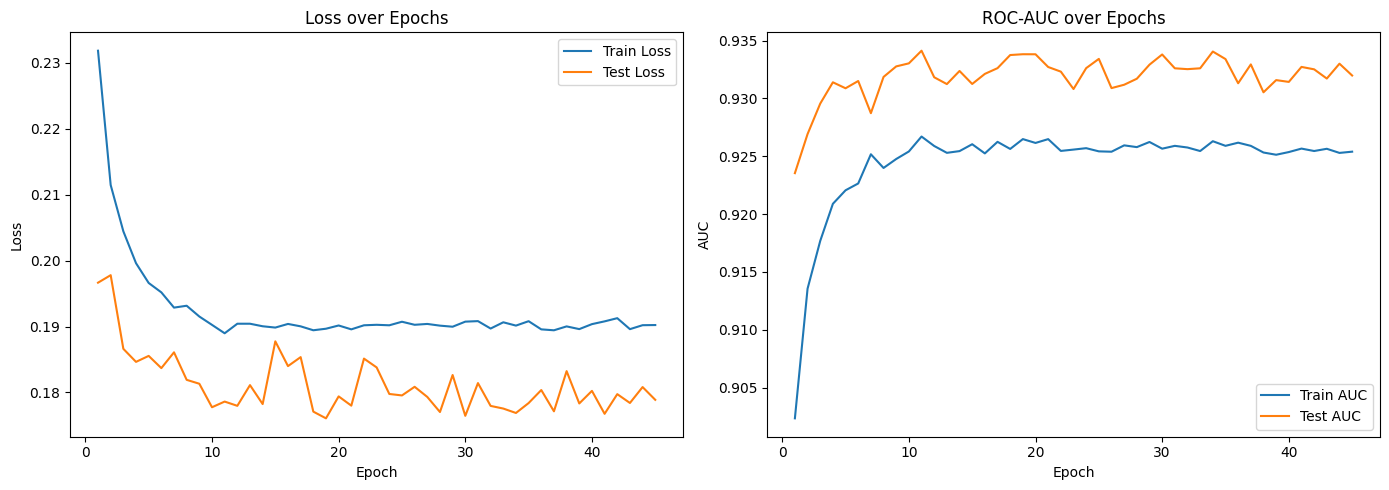

✅ График сохранён как compare_5_to_2.png


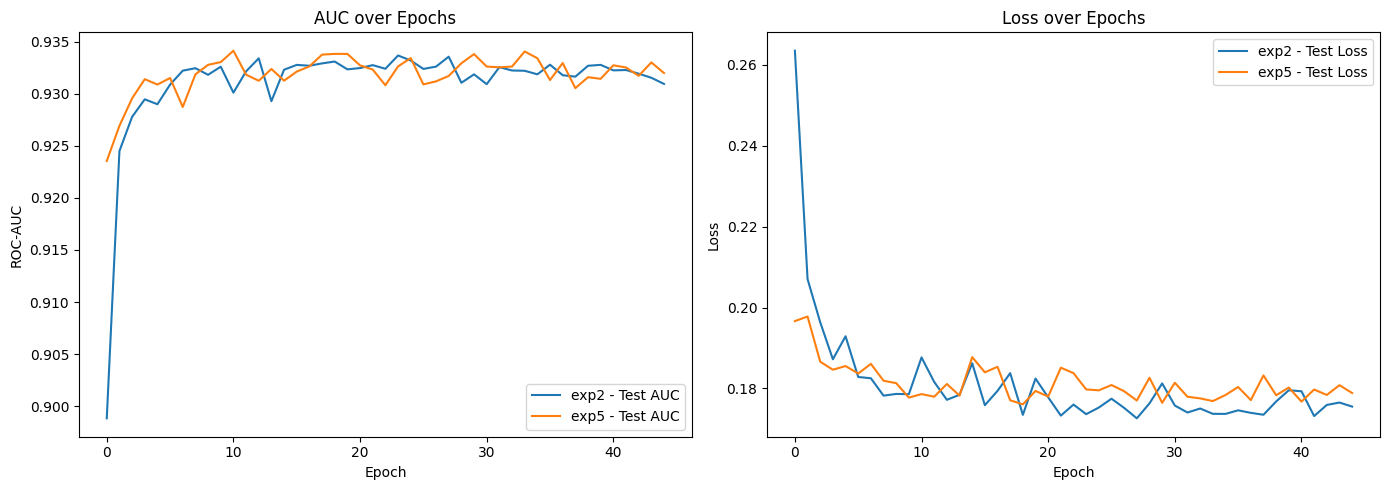

In [13]:
model = DropoutMLP(
            embedding_sizes=embedding_sizes,
            num_input_dim=X_train_num.shape[1],
            dropout_rate=dropout_rate,
            emb_dim=4,
    )

trainer = Trainer(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    learning_rate=0.05,
    weight_decay=0.001,
    epochs=45,
)

trainer.train()
prefix = f"experiment_5_best"

# Сохраняем график
trainer.plot_metrics(filename_prefix=prefix)

plot_all_experiments([experiment_2,
                      {
            'label': f'exp5',
            'train_losses': trainer.train_losses,
            'test_losses': trainer.test_losses,
            'train_aucs': trainer.train_aucs,
            'test_aucs': trainer.test_aucs
        }
                      ], 'test', 'compare_5_to_2')

In [14]:
print(max( enumerate(trainer.test_aucs), key = lambda x: x[1] ))
print(min( enumerate(trainer.test_losses), key = lambda x: x[1] ))

(10, np.float64(0.9341257842168545))
(18, 0.17606241619698734)


Выводы:

Большой weight_decay для нашей задачи не подходит.

Аналогично, learning_rate=0.1 слишком велик и график test_loss сильно колеблется.

Теперь, с Embedding-ами, модель действительно показывает себя лучше 2-го эксперимента, однако, к сожалению, это отражается в AUC, но не в самой loss функции. Тем не менее можно заметить, что модель обучается побыстрее и её десйтвительно можно назвать улучшением, относительно второй модели.

Налучшая модель: lr=0.05_wd=0.001

* Test AUC: 0.9341
* Test Loss: 0.1760

